#Project Title: Gesture Recognition with Leap Motion Dataset

##Description:
This project focuses on building a gesture recognition system using the Leap Motion Dataset. The dataset comprises hand gestures captured by the Leap Motion Controller, offering diverse hand movement data for analysis.

Dataset link: https://www.kaggle.com/datasets/gti-upm/leapgestrecog


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image

##Collecting the data

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [01:23<00:00, 27.3MB/s]
100% 2.13G/2.13G [01:23<00:00, 27.2MB/s]


In [6]:
import zipfile
import pandas as pd

archive_path = '/content/leapgestrecog.zip'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [7]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 64

data_path = "extracted_files/leapGestRecog"

In [8]:
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[4, 5, 6, ..., 4, 4, 5],
        [6, 5, 5, ..., 5, 6, 4],
        [5, 5, 4, ..., 4, 4, 4],
        ...,
        [5, 4, 4, ..., 4, 5, 4],
        [5, 6, 4, ..., 4, 4, 5],
        [5, 4, 5, ..., 5, 4, 4]], dtype=uint8),
 0]

In [9]:
random.shuffle(image_data)

In [10]:
data = []
labels = []
for features, label in image_data:
    data.append(features)
    labels.append(label)

In [11]:
print(labels)

[2, 9, 5, 3, 8, 9, 0, 9, 4, 6, 4, 9, 9, 6, 1, 1, 7, 8, 6, 9, 6, 4, 5, 8, 2, 3, 8, 9, 8, 8, 7, 2, 8, 5, 7, 0, 8, 0, 8, 2, 0, 7, 5, 2, 7, 1, 8, 5, 3, 0, 6, 1, 5, 1, 8, 4, 3, 8, 0, 4, 5, 4, 0, 3, 1, 2, 9, 5, 4, 5, 5, 7, 6, 8, 9, 6, 2, 5, 8, 7, 5, 0, 7, 1, 5, 9, 5, 9, 7, 8, 1, 6, 4, 9, 2, 7, 4, 6, 8, 9, 9, 5, 8, 9, 3, 3, 3, 9, 8, 6, 3, 6, 5, 4, 9, 0, 2, 3, 9, 2, 3, 1, 9, 6, 7, 9, 7, 4, 3, 6, 1, 0, 7, 4, 9, 5, 5, 9, 2, 9, 6, 7, 5, 4, 2, 7, 0, 6, 6, 0, 4, 7, 1, 3, 5, 9, 3, 3, 5, 6, 1, 0, 2, 4, 4, 9, 4, 5, 3, 2, 6, 9, 3, 3, 6, 6, 7, 8, 5, 1, 1, 2, 5, 2, 6, 3, 5, 7, 7, 4, 9, 4, 7, 0, 2, 5, 6, 2, 1, 0, 6, 5, 6, 2, 9, 4, 6, 5, 1, 1, 2, 9, 8, 6, 5, 7, 5, 5, 2, 1, 1, 2, 9, 9, 4, 0, 6, 8, 3, 1, 1, 0, 3, 7, 6, 7, 1, 1, 1, 7, 1, 9, 2, 3, 9, 8, 4, 0, 4, 7, 1, 2, 5, 4, 2, 3, 6, 4, 4, 0, 3, 2, 7, 4, 7, 5, 7, 9, 6, 5, 7, 2, 0, 0, 2, 3, 9, 5, 9, 2, 1, 5, 0, 5, 8, 4, 5, 1, 2, 2, 4, 2, 9, 3, 4, 4, 1, 8, 7, 5, 1, 4, 3, 1, 9, 8, 3, 0, 7, 4, 9, 2, 2, 9, 8, 1, 1, 3, 1, 1, 4, 3, 0, 7, 3, 2, 0, 6, 0, 0, 8, 0, 4, 

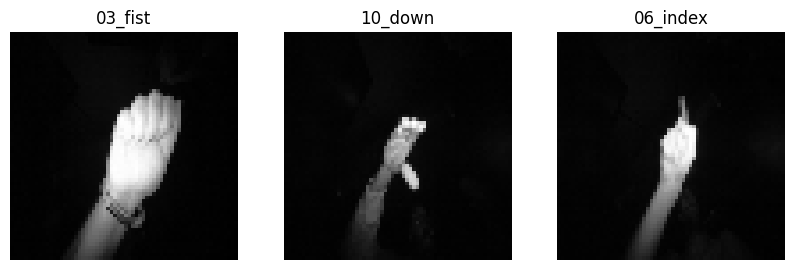

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(data[i], cmap='gray')
    ax[i].set_title(CATEGORIES[labels[i]])
    ax[i].axis('off')

In [13]:
pd.Series(labels).value_counts()

2    2000
9    2000
5    2000
3    2000
8    2000
0    2000
4    2000
6    2000
1    2000
7    2000
dtype: int64

##Preparation of data

In [14]:
def numpy_to_pil(image):
    return Image.fromarray(np.uint8(image))

train_transforms = transforms.Compose([
    transforms.Lambda(numpy_to_pil),
    transforms.RandomAutocontrast(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Lambda(numpy_to_pil),
    transforms.ToTensor()
])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [16]:
class GestDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]
        if self.transform:
            sample = self.transform(sample)
        return sample, target

In [17]:
train_dataset = GestDataset(X_train, y_train, train_transforms)
test_dataset = GestDataset(X_test, y_test, test_transforms)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [19]:
image, label = next(iter(train_loader))
print(image, label)

tensor([[[[0.0118, 0.0039, 0.0157,  ..., 0.0078, 0.0078, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0039],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0118, 0.0078],
          [0.0118, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
          [0.0078, 0.0157, 0.0118,  ..., 0.0078, 0.0078, 0.0039]]],


        [[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0039, 0.0039],
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0078, 0.0078,  ..., 0.0000, 0.0039, 0.0039],
          [0.0118, 0.0118, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0039]]],


        [[[0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0078, 0.0118],
          [0.0000, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0039,  ..

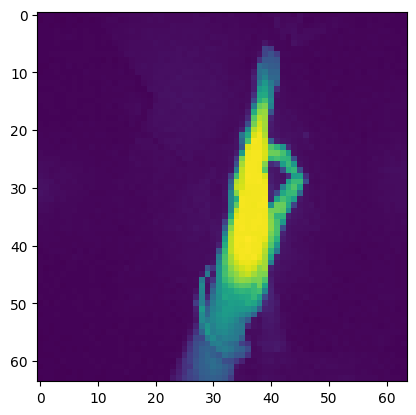

In [20]:
image_to_show = image[2].permute(1, 2, 0).numpy()
plt.imshow(image_to_show)
plt.show()

In [21]:
image[0].shape

torch.Size([1, 64, 64])

##Creating the model class

In [22]:
class GestModel(nn.Module):
  def __init__(self, num_classes):
    super(GestModel, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten()
    )
    self.classifier = nn.Sequential(
        nn.Linear(128 * 8 * 8, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.classifier(x)
    return x

In [23]:
model = GestModel(num_classes=len(CATEGORIES))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the model

In [24]:
for epoch in range(20):
    total_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

Epoch 5, Loss: 0.00011251951708436537
Epoch 10, Loss: 4.64579006461463e-06
Epoch 15, Loss: 1.6301096386541757e-06
Epoch 20, Loss: 6.73202578582277e-07


In [25]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

##Evaluating the model

In [28]:
from torchmetrics import Precision, Recall
metric_precision = Precision(task='multiclass', num_classes=10, average='macro')
metric_recall = Recall(task='multiclass', num_classes=10, average='macro')

model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    metric_precision(preds, labels)
    metric_recall(preds, labels)
precision_macro = metric_precision.compute()
recall_macro = metric_recall.compute()
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")

Precision: 0.9993
Recall: 0.9992


In [29]:
torch.save(model.state_dict(), 'gest_model.pth')